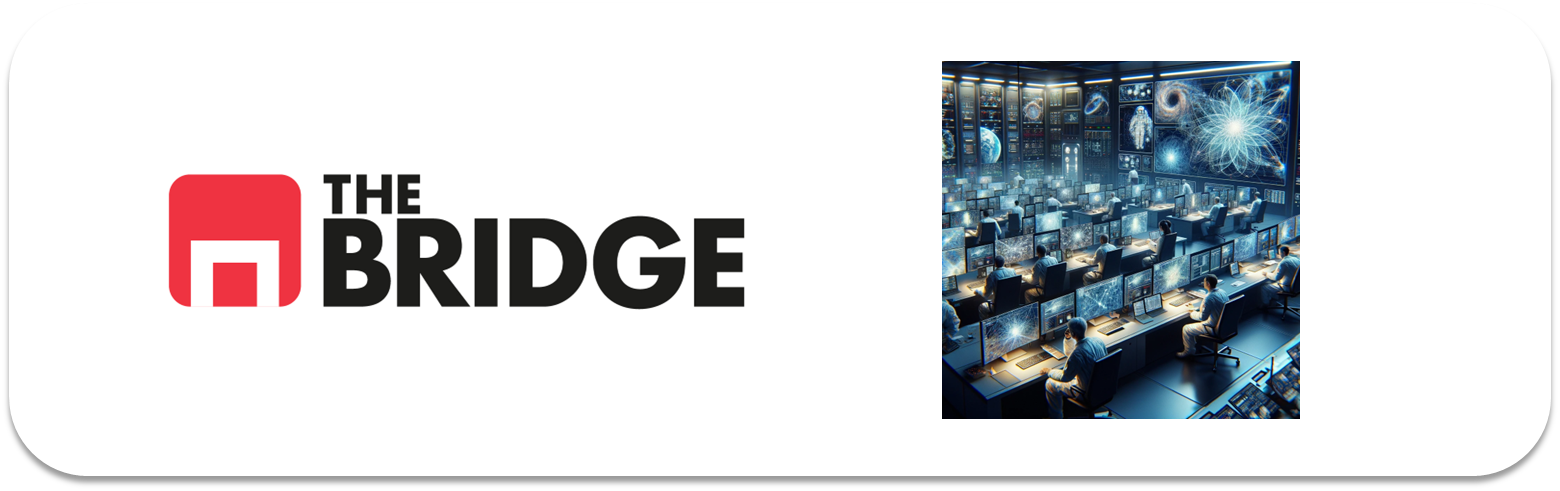

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [31]:
import os
import cv2
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.model_selection import train_test_split
from imageio import imread
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator


### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



1. Cargar las imágenes de la forma correcta.

In [2]:
# Definir rutas de las imagenes que están en otra carpeta
ROOT_PATH = '../Unidad 1/data/'
TRAIN_PATH = ROOT_PATH + "seg_train/"
TEST_PATH = ROOT_PATH + "seg_test/"

# Función para cargar imágenes y etiquetas de la anterior practica
def read_data(directorio, reshape_dim=(32, 32)):
    X = []
    y = []
    for folder in os.listdir(directorio):
        folder_path = os.path.join(directorio, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                image = imread(file_path)
                image = cv2.resize(image, reshape_dim)  # Redimensionamos a 32x32
                X.append(image)
                y.append(folder)
    return np.array(X), np.array(y)

# Cargar los datos
X_train, y_train = read_data(TRAIN_PATH)
X_test, y_test = read_data(TEST_PATH)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


C:\Users\tebar\AppData\Local\Temp\ipykernel_3768\2480303085.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(file_path)


X_train shape: (14034, 32, 32, 3), y_train shape: (14034,)
X_test shape: (3000, 32, 32, 3), y_test shape: (3000,)


Se hace una visualización aleatoria de las mismas creando una función para ello.

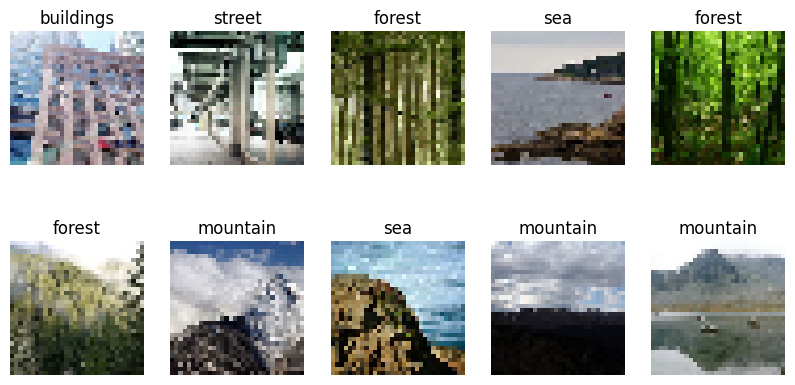

Distribución de clases en el conjunto de entrenamiento:
buildings: 2191 imágenes
forest: 2271 imágenes
glacier: 2404 imágenes
mountain: 2512 imágenes
sea: 2274 imágenes
street: 2382 imágenes


In [6]:
def visualizar_imagenes(X_data, y_data, num_imagenes=10):

    indices = np.random.choice(len(X_data), num_imagenes, replace=False)
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(X_data[indices[i]])  
        ax.set_title(y_data[indices[i]])  
        ax.axis('off')   
    plt.show()


visualizar_imagenes(X_train, y_train)


# Conteo para ver si estan balanceadas
unique, counts = np.unique(y_train, return_counts=True)
print("Distribución de clases en el conjunto de entrenamiento:")
for cls, count in zip(unique, counts):
    print(f"{cls}: {count} imágenes")

Normalización de los datos

In [5]:
print(f"Valor mínimo: {X_train.min()}, Valor máximo: {X_train.max()}")
print(f"Media: {X_train.mean():.2f}, Desviación estándar: {X_train.std():.2f}")

# Normalización 
X_train = X_train / 255.0
X_test = X_test / 255.0

print("\nDatos normalizados:")
print(f"Nuevo valor mínimo: {X_train.min()}, Nuevo valor máximo: {X_train.max()}")

Valor mínimo: 0, Valor máximo: 255
Media: 113.93, Desviación estándar: 68.94

Datos normalizados:
Nuevo valor mínimo: 0.0, Nuevo valor máximo: 1.0


Se crean funciones para la visualización de los resultados posteriormente.

In [7]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt=".2f", xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

In [8]:
def plot_metrics(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    
    plt.show()

Pasar las etiquetas a numéricas

In [14]:
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

print(y_train[:10])

[3 4 2 4 3 1 2 4 2 0]


2. Elegimos el modelo base MobileNetV2

In [10]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

C:\Users\tebar\AppData\Local\Temp\ipykernel_3768\1777297700.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


3. Transfer-learning con una cabeza 2 capas densas ocultas y una de salida

In [11]:
# Congelar las capas del modelo base
base_model.trainable = False

# Crear el modelo de transfer learning con una cabeza densa
model_transfer = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(np.unique(y_train)), activation='softmax')  
])

model_transfer.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Ajustar modelo y evaluar para obtener predicciones

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Ajustar el modelo 
history_transfer = model_transfer.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Evaluar el modelo de transfer learning
loss, accuracy = model_transfer.evaluate(X_test, y_test)
print(f"Evaluación Transfer Learning - Loss: {loss}, Accuracy: {accuracy}")

# Predecir sobre el set de test
y_pred = np.argmax(model_transfer.predict(X_test), axis=1)

Epoch 1/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 23s 57ms/step - accuracy: 0.4075 - loss: 1.5050 - val_accuracy: 0.5223 - val_loss: 1.2322
Epoch 2/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.5160 - loss: 1.2072 - val_accuracy: 0.5329 - val_loss: 1.2090
Epoch 3/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.5360 - loss: 1.1599 - val_accuracy: 0.5347 - val_loss: 1.2014
Epoch 4/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - accuracy: 0.5496 - loss: 1.1193 - val_accuracy: 0.5432 - val_loss: 1.1965
Epoch 5/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - accuracy: 0.5681 - loss: 1.0855 - val_accuracy: 0.5343 - val_loss: 1.2001
Epoch 6/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 16s 57ms/step - accuracy: 0.5853 - loss: 1.0676 - val_accuracy: 0.5294 - val_loss: 1.2092
Epoch 7/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.5754 - loss: 1.0481 - val_accuracy: 0.5356 - val_loss: 1.2018
Epoch 8/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.5996 - loss: 1.0174 - 

In [17]:
print("Classification Report")
print(classification_report(y_test, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.47      0.59      0.52       437
           1       0.74      0.82      0.78       474
           2       0.46      0.32      0.37       553
           3       0.46      0.54      0.50       525
           4       0.49      0.50      0.50       510
           5       0.46      0.38      0.42       501

    accuracy                           0.52      3000
   macro avg       0.51      0.52      0.51      3000
weighted avg       0.51      0.52      0.51      3000



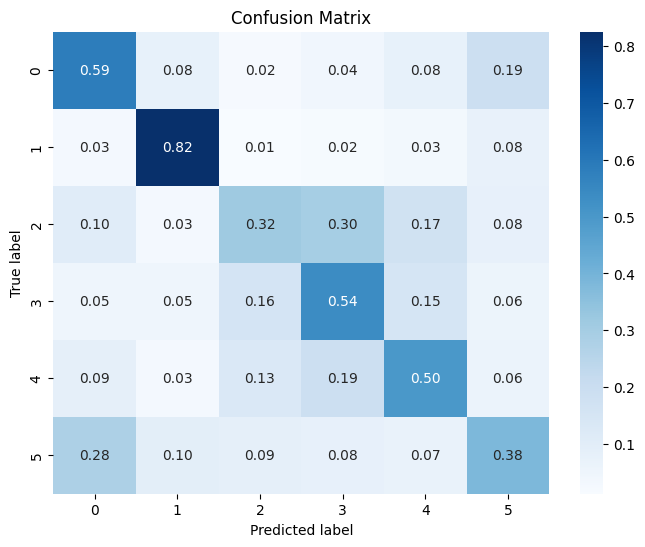

In [18]:
plot_confusion_matrix(y_test, y_pred, classes=np.unique(y_train))

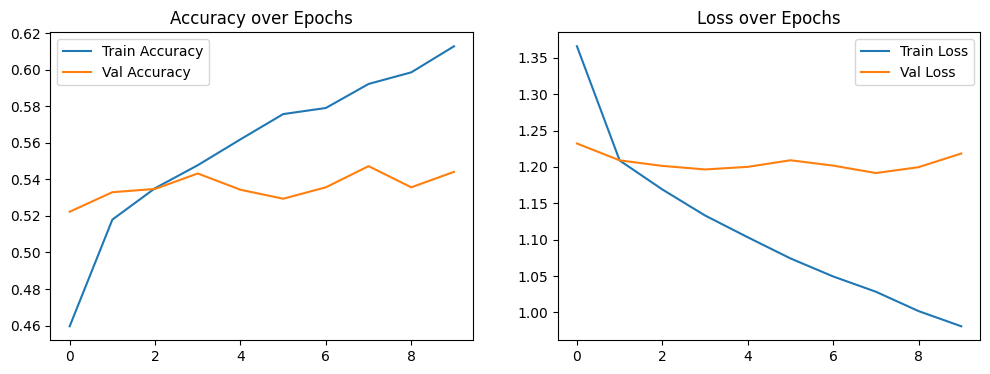

In [19]:
plot_metrics(history_transfer)

4. Fine-tuning con la misma cabeza

In [20]:
# Descongelar algunas capas del modelo base 
base_model.trainable = True 

# Congelar todas las capas antes de 100
for layer in base_model.layers[:100]:
    layer.trainable = False

# Volver a compilar el modelo 
model_transfer.compile(optimizer=tf.keras.optimizers.Adam(),
                       loss='sparse_categorical_crossentropy', 
                       metrics=['accuracy'])

Ajustar el modelo y evaluar

In [21]:
history_fine_tuning = model_transfer.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Evaluar
loss, accuracy = model_transfer.evaluate(X_test, y_test)
print(f"Evaluación Fine-Tuning - Loss: {loss}, Accuracy: {accuracy}")

# Predecir 
y_pred_fine_tuning = np.argmax(model_transfer.predict(X_test), axis=1)

Epoch 1/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 57s 132ms/step - accuracy: 0.4284 - loss: 4.8618 - val_accuracy: 0.3419 - val_loss: 15.2929
Epoch 2/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 33s 119ms/step - accuracy: 0.6093 - loss: 1.0280 - val_accuracy: 0.1866 - val_loss: 7.7235
Epoch 3/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 35s 123ms/step - accuracy: 0.6524 - loss: 0.8983 - val_accuracy: 0.2560 - val_loss: 3.8873
Epoch 4/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 37s 131ms/step - accuracy: 0.6960 - loss: 0.8344 - val_accuracy: 0.2952 - val_loss: 2.3547
Epoch 5/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 46s 164ms/step - accuracy: 0.7253 - loss: 0.7440 - val_accuracy: 0.4506 - val_loss: 1.4601
Epoch 6/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 46s 163ms/step - accuracy: 0.7383 - loss: 0.7146 - val_accuracy: 0.6630 - val_loss: 0.8888
Epoch 7/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 33s 116ms/step - accuracy: 0.7616 - loss: 0.6632 - val_accuracy: 0.7378 - val_loss: 0.7585
Epoch 8/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 32s 115ms/step - accuracy: 0.7749 - loss: 

Mostrar resultados

In [27]:
print("Classification Report")
print(classification_report(y_test, y_pred_fine_tuning))

Classification Report
              precision    recall  f1-score   support

           0       0.59      0.83      0.69       437
           1       0.95      0.88      0.91       474
           2       0.81      0.40      0.54       553
           3       0.54      0.84      0.66       525
           4       0.77      0.67      0.72       510
           5       0.86      0.71      0.78       501

    accuracy                           0.71      3000
   macro avg       0.75      0.72      0.71      3000
weighted avg       0.75      0.71      0.71      3000



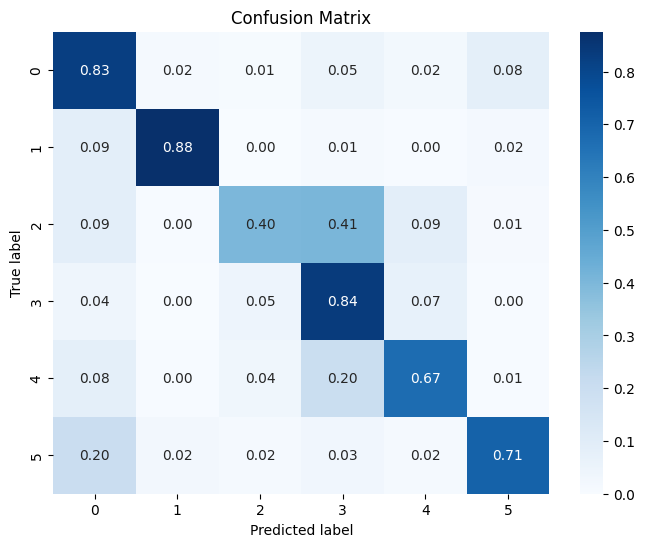

In [23]:
plot_confusion_matrix(y_test, y_pred_fine_tuning, classes=np.unique(y_train))

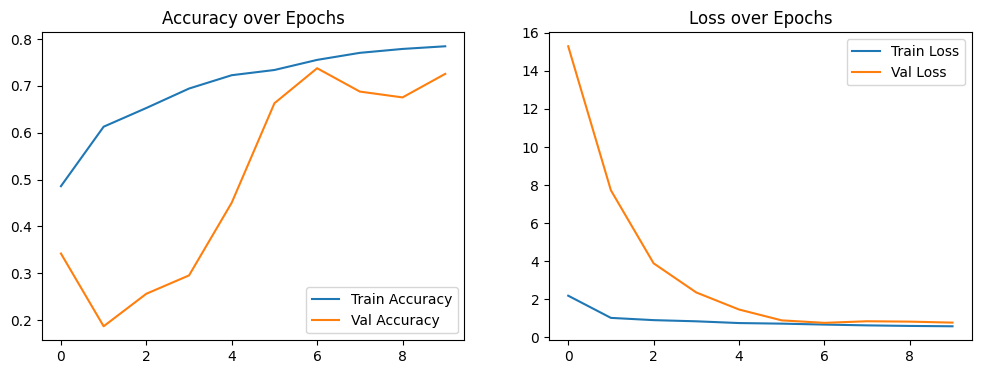

In [24]:
plot_metrics(history_fine_tuning)

5. Comparar con los resultados de una red convolucional

In [25]:
# Crear la red convolucional 
model_custom = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(np.unique(y_train)), activation='softmax')
])

# Compilar el modelo
model_custom.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


c:\Users\tebar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
# Entrenar el modelo 
history_custom = model_custom.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Evaluar el modelo 
loss, accuracy = model_custom.evaluate(X_test, y_test)
print(f"Evaluación Red Convolucional Ad-hoc - Loss: {loss}, Accuracy: {accuracy}")

# Predecir 
y_pred_custom = np.argmax(model_custom.predict(X_test), axis=1)


Epoch 1/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.4073 - loss: 1.3997 - val_accuracy: 0.6398 - val_loss: 0.9450
Epoch 2/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6368 - loss: 0.9373 - val_accuracy: 0.6411 - val_loss: 0.9359
Epoch 3/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.7035 - loss: 0.8021 - val_accuracy: 0.6990 - val_loss: 0.8001
Epoch 4/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.7355 - loss: 0.7252 - val_accuracy: 0.7342 - val_loss: 0.7452
Epoch 5/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.7650 - loss: 0.6559 - val_accuracy: 0.7502 - val_loss: 0.7096
Epoch 6/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.7807 - loss: 0.5997 - val_accuracy: 0.7703 - val_loss: 0.6593
Epoch 7/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.7909 - loss: 0.5752 - val_accuracy: 0.7698 - val_loss: 0.6415
Epoch 8/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.8062 - loss: 0.5141 - val_accu

In [28]:
# Resultados
print("Classification Report")
print(classification_report(y_test, y_pred_custom))

Classification Report
              precision    recall  f1-score   support

           0       0.78      0.61      0.68       437
           1       0.93      0.89      0.91       474
           2       0.74      0.78      0.76       553
           3       0.78      0.70      0.74       525
           4       0.69      0.79      0.73       510
           5       0.73      0.83      0.78       501

    accuracy                           0.77      3000
   macro avg       0.78      0.77      0.77      3000
weighted avg       0.77      0.77      0.77      3000



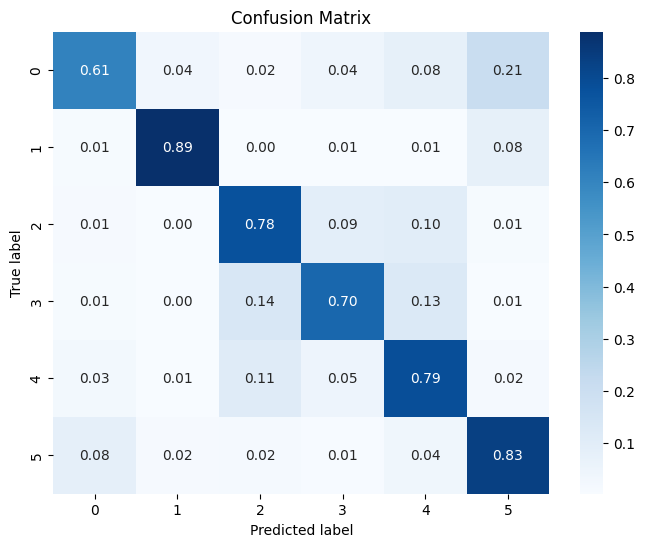

In [29]:
plot_confusion_matrix(y_test, y_pred_custom, classes=np.unique(y_train))

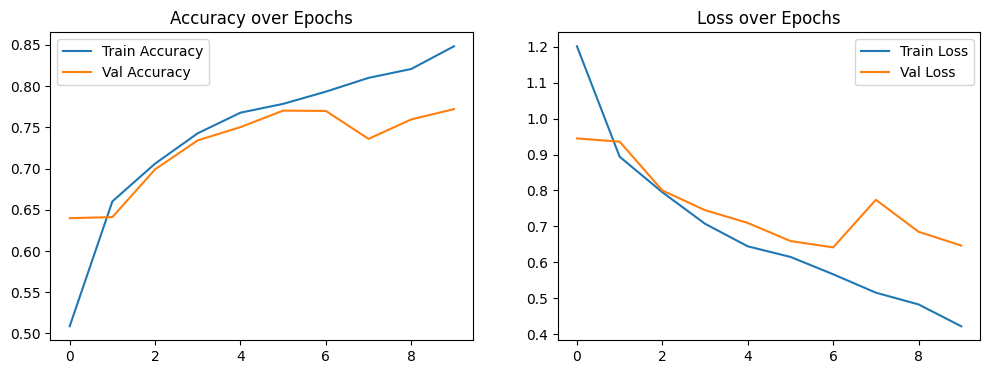

In [30]:
plot_metrics(history_custom)

6. EXTRA: TL con aumento de imágenes

In [32]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [33]:
history_transfer_augmented = model_transfer.fit(datagen.flow(X_train, y_train, batch_size=32),
                                               epochs=10, validation_data=(X_val, y_val))

loss, accuracy = model_transfer.evaluate(X_test, y_test)
print(f"Evaluación Transfer Learning con Aumento - Loss: {loss}, Accuracy: {accuracy}")

y_pred_transfer_augmented = np.argmax(model_transfer.predict(X_test), axis=1)


Epoch 1/10


c:\Users\tebar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


281/281 ━━━━━━━━━━━━━━━━━━━━ 39s 137ms/step - accuracy: 0.6595 - loss: 0.9819 - val_accuracy: 0.7079 - val_loss: 0.7500
Epoch 2/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 32s 115ms/step - accuracy: 0.6710 - loss: 0.9100 - val_accuracy: 0.7364 - val_loss: 0.7204
Epoch 3/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 32s 114ms/step - accuracy: 0.6857 - loss: 0.8543 - val_accuracy: 0.7498 - val_loss: 0.8151
Epoch 4/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 32s 114ms/step - accuracy: 0.6828 - loss: 0.8835 - val_accuracy: 0.7498 - val_loss: 0.7989
Epoch 5/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 33s 117ms/step - accuracy: 0.6967 - loss: 0.8290 - val_accuracy: 0.7747 - val_loss: 0.6945
Epoch 6/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - accuracy: 0.7105 - loss: 0.7954 - val_accuracy: 0.7395 - val_loss: 0.7690
Epoch 7/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 49s 174ms/step - accuracy: 0.7096 - loss: 0.8004 - val_accuracy: 0.7084 - val_loss: 0.8762
Epoch 8/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 41s 144ms/step - accuracy: 0.6966 - loss: 0.8282 - val

In [34]:
print("Classification Report:")
print(classification_report(y_test, y_pred_transfer_augmented))

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.48      0.59       437
           1       0.74      0.96      0.84       474
           2       0.56      0.63      0.59       553
           3       0.50      0.75      0.60       525
           4       0.83      0.41      0.55       510
           5       0.78      0.70      0.74       501

    accuracy                           0.66      3000
   macro avg       0.70      0.65      0.65      3000
weighted avg       0.69      0.66      0.65      3000



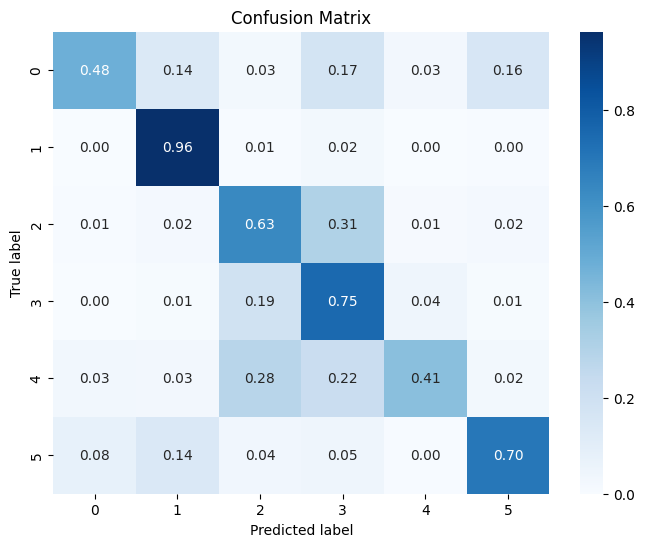

In [35]:
plot_confusion_matrix(y_test, y_pred_transfer_augmented, classes=np.unique(y_train))

Comparacion global

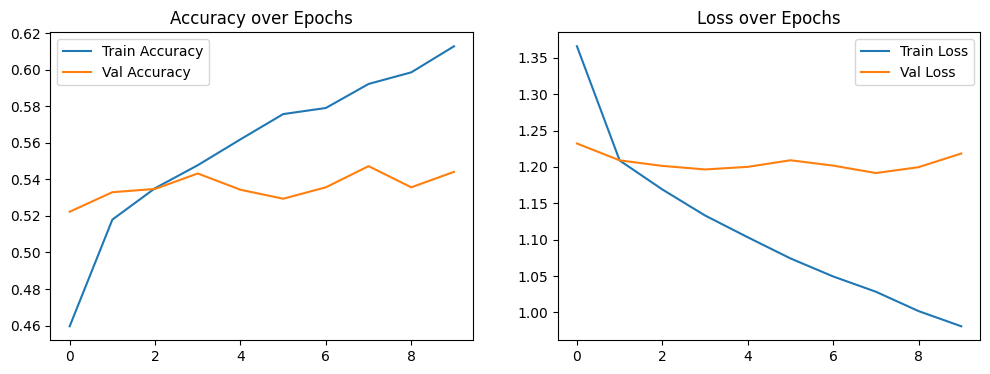

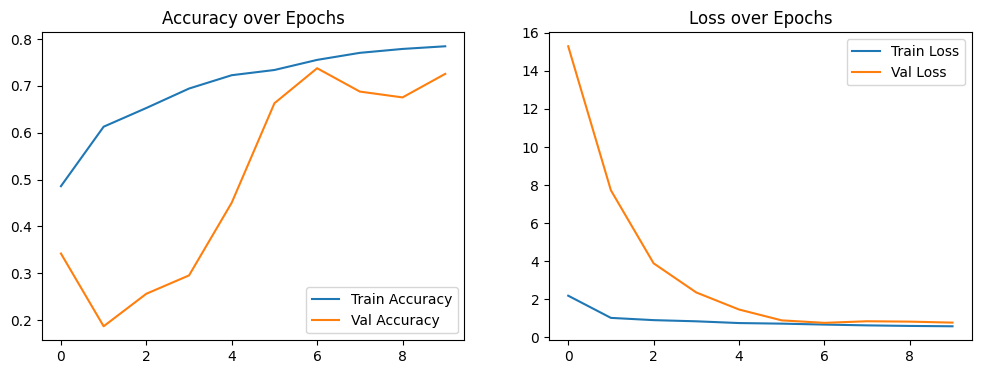

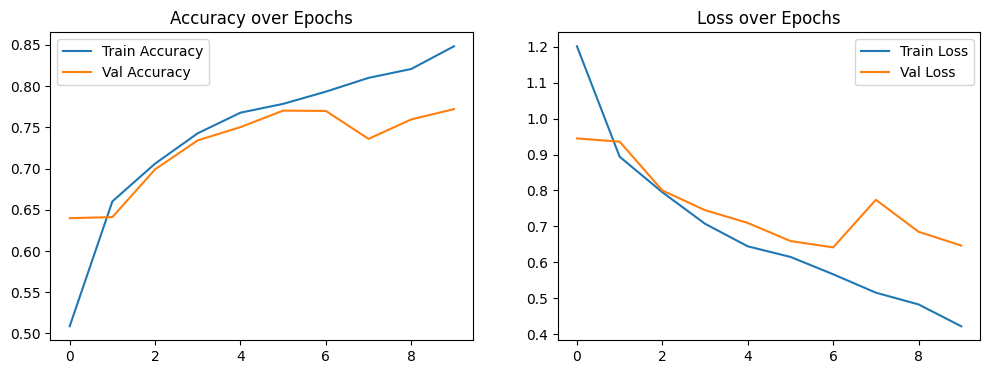

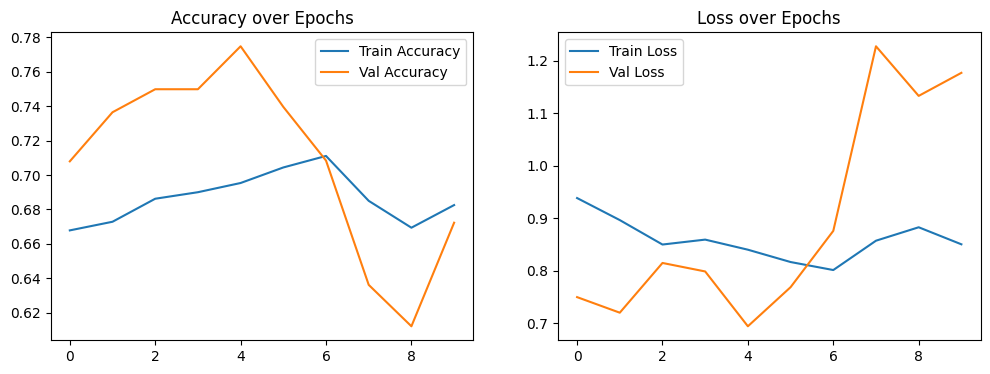

In [36]:
# Gráficas de métricas
plot_metrics(history_transfer)
plot_metrics(history_fine_tuning)
plot_metrics(history_custom)
plot_metrics(history_transfer_augmented)
